In [1]:
import random
import itertools
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display

In [6]:
df = pd.read_csv('sp_500.csv')
tickers = df['Symbol'].tolist()[:100]
tickers = [ticker for ticker in tickers if ticker not in ['BRK.B', 'CTLT', 'BF.B', 'ABC', 'ATVI']]

In [7]:
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2025, 2, 24)

n_tickers_selected = 4
n_combinations = 200

sampled_combinations = random.sample(list(itertools.combinations(tickers, n_tickers_selected)), n_combinations)

In [8]:
all_portfolios = []
rf = 0.0415

for combination in sampled_combinations:
    data = yf.download(list(combination), start= start_date, end = end_date, progress= False)["Close"]
    returns = data.pct_change().dropna()
    covariance_matrix = returns.cov()

    annual_returns = returns.mean() * 252
    annual_cov = covariance_matrix * 252

    # Numero de simulaciones de ponderaciones
    num_portafolios = 10000

    weights_array = np.zeros((num_portafolios, n_tickers_selected))
    returns_array = np.zeros(num_portafolios)
    risk_array = np.zeros(num_portafolios)
    sharpe_array = np.zeros(num_portafolios)

    for i in range(num_portafolios):
        # generas los pesos aleatorios para cada portafolio
        weights = np.random.random(n_tickers_selected)
        weights = weights / np.sum(weights)

        # obteniendo rendimiento y volatilidad esperada anual por portafolio
        portfolio_return = np.dot(annual_returns, weights)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

        # guardando historicos
        weights_array[i, :] = weights
        returns_array[i] = portfolio_return
        risk_array[i] = portfolio_risk
        sharpe_array[i] = (portfolio_return - rf) / portfolio_risk

    portfolios = pd.DataFrame({
        "Returns": returns_array,
        "Risk": risk_array,
        "Sharpe": sharpe_array
    })

    for i, symbol in enumerate(combination):
        portfolios[symbol + " Weight"] = weights_array[:, i]

    all_portfolios.append(portfolios)

In [41]:
todo = pd.concat(all_portfolios)

sorted_todo = todo.sort_values("Sharpe", ascending=False)

selected_rows = []
used_tickers = set()
for idx, row in sorted_todo.iterrows():
    # extract tickers from non-NaN weight columns
    row_tickers = [col.replace(" Weight", "") for col in todo.columns if col.endswith("Weight") and pd.notna(row[col])]
    if set(row_tickers) & used_tickers:
        continue
    selected_rows.append(row)
    used_tickers.update(row_tickers)
    if len(selected_rows) >= 10:
        break

top_10 = pd.DataFrame(selected_rows)
# Rename weight columns to only show the ticker name
top_10.rename(columns=lambda col: col.replace(" Weight", "") if col.endswith(" Weight") else col, inplace=True)
top_10

,Returns,Risk,Sharpe,AES,AVY,KMX,CE,APH,APA,ANET,...,AMCR,AAPL,CZR,ARE,BDX,AOS,ALL,ANSS,BR,ADBE
9485,0.258170,0.157999,1.371342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2718,0.304197,0.198722,1.321931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6499,0.356652,0.246788,1.277012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6583,0.225029,0.174312,1.052878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031178,NaN,NaN
6692,0.253367,0.214032,0.989883,NaN,NaN,NaN,NaN,NaN,NaN,0.355013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077,0.236570,0.223753,0.871806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9540,0.203178,0.209034,0.773454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.491506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4804,0.202319,0.212652,0.756257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6214,0.243779,0.270070,0.748988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6590,0.204830,0.232309,0.703072,NaN,0.232351,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
sharpe_df = []
for i in range(10):
    clean_todo = top_10.iloc[i:i+1]
    clean_todo = clean_todo.dropna(axis=1, how='all')
    sharpe_df.append(clean_todo)

In [44]:
max = sharpe_df[0]

In [ ]:
tickers = max.columns[3:-1]
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2025, 2, 24)
weights = max.values[0][3:-1]

In [50]:
def get_data(stocks, start_date, end_date):
    prices = yf.download(stocks, start_date, end_date, progress = False)["Close"]
    returns = prices.pct_change().dropna()
    mean_returns = returns.mean()
    cov_returns = returns.cov()
    return mean_returns, cov_returns, prices

In [51]:
def simular_precios(mean_returns, cov_returns, prices, num_dias, stocks, weights):

    N = 10000
    portfolio_return = np.dot(weights, mean_returns)

    portfolio_simulated_returns = np.zeros((num_dias, N)) # filas x columnas
    mean_returns = np.full(shape = (num_dias, len(stocks)), fill_value=portfolio_return)

    for m in range(N):
        L = np.linalg.cholesky(cov_returns)
        Z = np.random.normal(size=(num_dias, len(stocks))) # Matriz de n_dias (filas) y n_stocks (columnas)
        daily_returns = mean_returns.T + np.dot(L, Z.T)
        portfolio_simulated_returns [:, m] = np.cumprod(np.dot(weights, daily_returns) + 1)
    
    return portfolio_simulated_returns

In [70]:
stocks = max.columns[3:-1].tolist()
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2025, 2, 24)
weights = max.values[0][3:-1]
num_dias = 14

In [71]:
mean_returns, cov_returns, prices = get_data(stocks, start_date, end_date)
portafolios_simulados = simular_precios(mean_returns, cov_returns, prices, num_dias, stocks, weights)

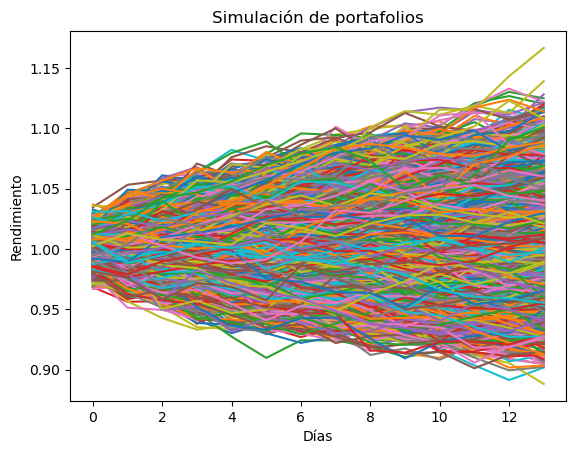

In [72]:
plt.plot(portafolios_simulados)
plt.ylabel('Rendimiento')
plt.xlabel('Días')
plt.title('Simulación de portafolios')
plt.show()

In [75]:
np.percentile(portafolios_simulados[-1], 5) - 1

-0.04723967109677807